In [1]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [2]:
%load_ext autoreload
%autoreload 2

# Boston data

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
data = boston.data
target = boston.target
features = boston.feature_names

Summary of Boston data
---
* data: (506, 13)
* target: (506, )
* features: (13, ) `['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']`

# SciKit Learn Linear Regression

## Data prep
* Split the data into two folds: train and test sets where 354 and 152 examples repspectively. 
* For the sake of consistency, reshape 1d-array into 2d-array for target: for example, (152, ) to (152, 1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

In [7]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## Regression
* preds: (152, ) or (152, 1)? (152, 1) (since y_train is 2d-array?)
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* `lr` has two attrributes: `coef_` and `intercept_`
* 


In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [9]:
print(lr.coef_, lr.intercept_)

[[-1.1809e-01  3.0322e-02  4.0264e-02  2.7948e+00 -1.9056e+01  3.3897e+00
   2.5366e-02 -1.2657e+00  3.0264e-01 -1.0793e-02 -1.0757e+00  9.2812e-03
  -5.8717e-01]] [39.8792]


What's the meaning of the largest value in coeffifients? Most important feature?

In [10]:
max_coef_idx = np.argmax(lr.coef_[0])
features[max_coef_idx]

'RM'

In [11]:
import matplotlib.pyplot as plt

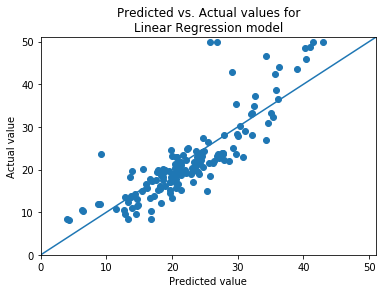

In [12]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
#plt.savefig("")

## Testing chaning feature

Text(0.5, 1.0, 'Relationship between most\nimportant feature and target')

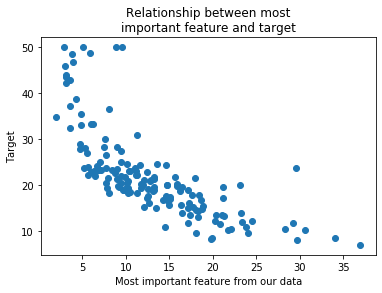

In [13]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target")

Non-linear relationship

## Model Error

In [14]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

In [15]:
def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [16]:
round(mae(preds, y_test), 4)

3.5671

In [17]:
round(rmse(preds, y_test), 4)

5.0476

In [18]:
np.round(lr.coef_, 2)

array([[-1.200e-01,  3.000e-02,  4.000e-02,  2.790e+00, -1.906e+01,
         3.390e+00,  3.000e-02, -1.270e+00,  3.000e-01, -1.000e-02,
        -1.080e+00,  1.000e-02, -5.900e-01]])

# Linear Regression from Scratch

In [22]:
def forward_linear_regression(X_batch: ndarray, 
                              y_batch: ndarray, 
                              weights: Dict[str, ndarray]
                              )->Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    assert X_batch.shape[0] == y_batch.shape[0]
    assert X_batch.shape[1] == weights['W'].shape[0]
    assert weights['B'].shape == (1, 1)
    
    N = np.dot(X_batch, weights['W'])
    P = N + weights['B']
    
    loss = np.mean(np.power(y_batch - P, 2))
    
    #forward_info: Dict[str, ndarray] = {}
    forward_info = dict()
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

In [23]:
def to_2d_np(a: ndarray, type: str = "col")-> ndarray:
    '''
    Turns a 1D tensor into 2D
    '''
    assert a.ndim == 1, "Input tensors must be 1 dimensional"
    
    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)
    else:
        raise ValueError("type should be 'col' or ''row'.")

In [24]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permuttion, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]